In [ ]:
import pandas as pd
import warnings
import os
from tqdm import tqdm

# Ignore FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Define global variables and paths
classification_file_path = './data/classification.txt'
connections_file_path = './data/connections.txt'
synapses_file_path = './data/synapses.txt'
neuron_types = ['LC11', 'T2', 'T2a', 'T3', 'TmY3', 'Y3', 'TmY4', 'TmY9q', 'TmY9q-', 'LC11', 'LC4', 'LC18', 'LC21', 'LC17', 'LC15', 'LC25']

output_dir = './result/Neuron_Paths/'

# Create output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Read the data
classification = pd.read_csv(classification_file_path)
connections = pd.read_csv(connections_file_path)
synapses = pd.read_csv(synapses_file_path)

# Get the IDs of right-side L2 neurons
L2_right_ids = classification[(classification['cell_type'] == 'L2') & (classification['side'] == 'right')]['root_id'].tolist()

# Set of allowed cell types
allowed_cell_types = {'Pm','LPi','T2', 'T3', 'T4', 'T5', 'Tm', 'Mi', 'Li', 'L2', 'L3', 'L5', 'DM', 'Y','LC','LM'}

# DFS to find paths and compute weights
def dfs(neuron_id, visited, connections, current_path, all_paths, current_weight, target_ids):
    if neuron_id in visited or len(current_path) >= 5:
        return
    visited.add(neuron_id)
    current_path.append(neuron_id)

    upstream_neurons = connections[connections['post_root_id'] == neuron_id]

    for _, row in upstream_neurons.iterrows():
        pre_id = row['pre_root_id']
        syn_count = row['syn_count']
        nt_type = row['nt_type']

        # Get the cell_type of the upstream neuron
        pre_cell_type = classification.loc[classification['root_id'] == pre_id, 'cell_type']
        
        if pre_cell_type.empty:
            continue
        
        # Check if the upstream neuron meets the criteria
        pre_cell_type_value = pre_cell_type.values[0]  # Get the first value
        
        if not isinstance(pre_cell_type_value, str) or not any(allowed in pre_cell_type_value for allowed in allowed_cell_types):
            continue  # Skip neurons that do not meet the criteria
        
        # Filter synapse types
        if nt_type == 'GABA' or nt_type == 'GLUT':
            syn_count = -abs(syn_count)
        elif nt_type == 'ACH':
            syn_count = abs(syn_count)
        else:
            continue
        
        # Get the output synapses of the upstream neuron
        output_synapses = synapses.loc[synapses['root_id'] == pre_id, 'output synapses']
        if not output_synapses.empty:
            output_synapses = output_synapses.values[0]
            weight = float(syn_count) / output_synapses
            if abs(weight) < 0.01 and syn_count < 5:
                continue
            # Update the current weight
            new_weight = current_weight * weight
            
            # Recursively search upstream neurons
            dfs(pre_id, visited, connections, current_path, all_paths, new_weight, target_ids)

    # If the current neuron is a target neuron (L2 or L2), save the path and weight
    if neuron_id in target_ids:
        all_paths.append((list(current_path), current_weight))
    
    # Backtrack
    current_path.pop()
    visited.remove(neuron_id)

# Process each neuron type
for neuron_type in neuron_types:
    # Set file path
    file_path = f'./data/Object_Neuron/{neuron_type}.txt'

    # Read neuron ID list
    with open(file_path, 'r') as f:
        content = f.read()
    neuron_ids = [int(item.strip()) for item in content.split(',')]

    # Initialize L2 and L2 weight dictionary
    L2_weights = {L2_id: 0 for L2_id in L2_right_ids}
    neuron_type_output_dir = os.path.join(output_dir, f'{neuron_type}')
    L2_output_dir = os.path.join(neuron_type_output_dir, 'L2')

    # Create directories to save L2 weights
    if not os.path.exists(L2_output_dir):
        os.makedirs(L2_output_dir)

    # Perform DFS for each neuron
    for neuron_id in tqdm(neuron_ids, desc=f"Processing {neuron_type} Neurons"):
        visited = set()
        current_path = []
        all_paths = []

        # Start DFS to find paths to L2 neurons
        dfs(neuron_id, visited, connections, current_path, all_paths, 1, target_ids=L2_right_ids)

        # Update the weight sum for each L2 neuron
        for path, weight in all_paths:
            target_neuron_id = path[-1]  # Get the neuron ID of the path's endpoint
            if target_neuron_id in L2_right_ids:
                L2_weights[target_neuron_id] += weight

        # Save the L2 weights to a file
        L2_output_file_path = os.path.join(L2_output_dir, f'{neuron_id}.txt')
        with open(L2_output_file_path, 'w') as f:
            for L2_id, total_weight in L2_weights.items():
                f.write(f'{L2_id}: {total_weight}\n')

        # Reset the weight dictionary for the next iteration
        L2_weights = {L2_id: 0 for L2_id in L2_right_ids}


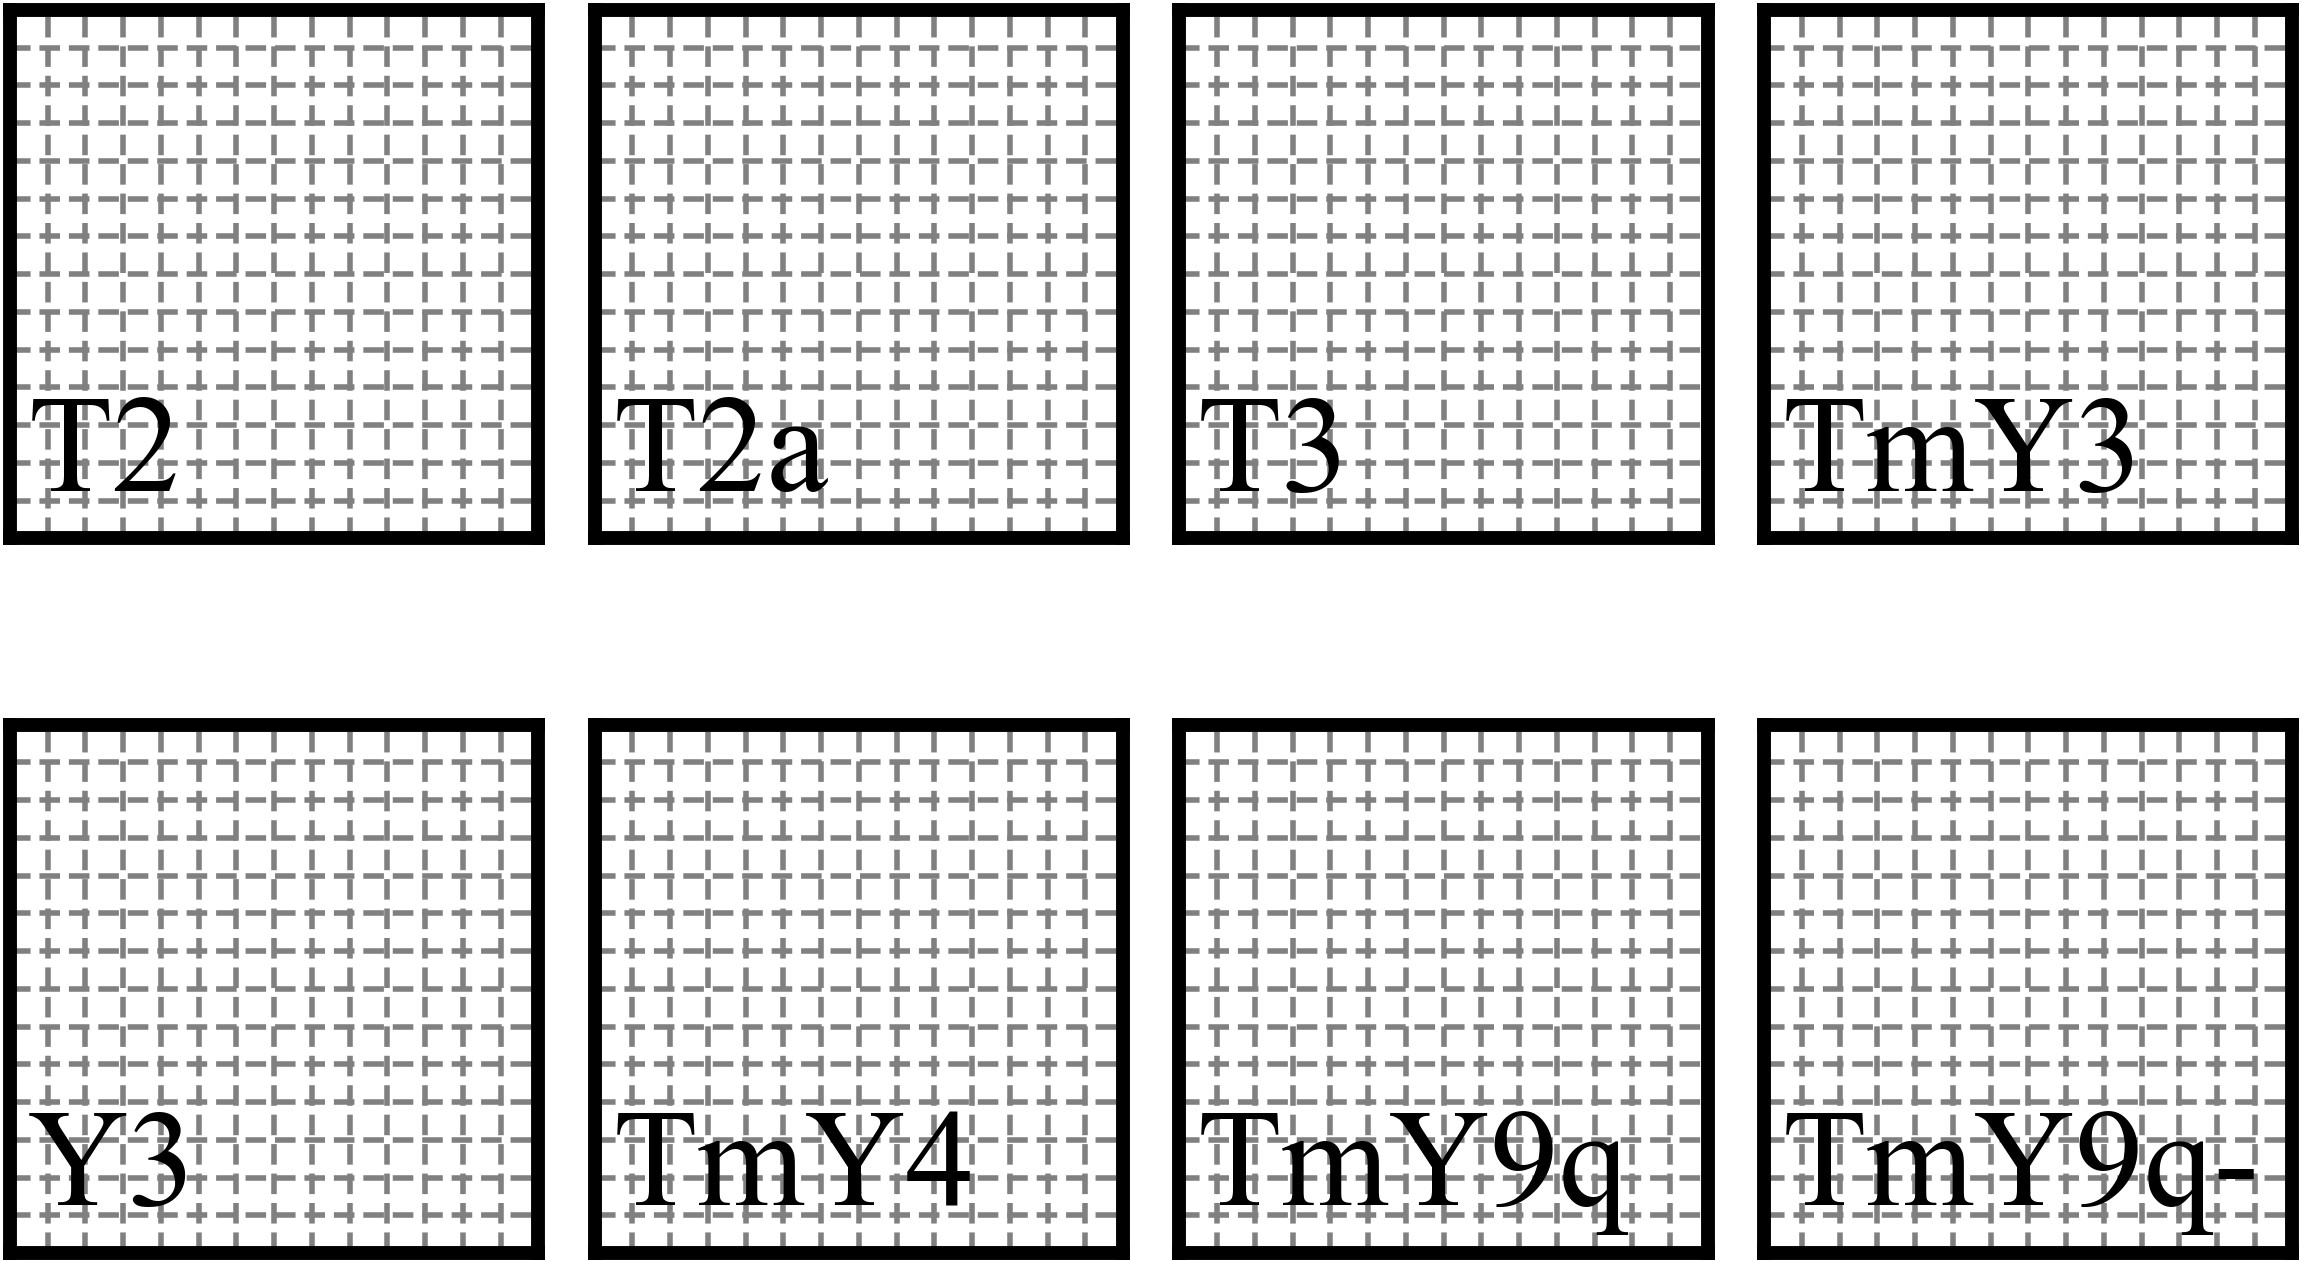

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
from matplotlib.colors import Normalize

warnings.filterwarnings("ignore", category=FutureWarning)

neuron_types = ['T2','T2a','T3','TmY3','Y3','TmY4','TmY9q','TmY9q-']  # 需要绘制的神经元类型名称
Lamina = 'L2'

classification_file_path = './data/classification.txt'
column_assignment_file_path = './data/column_assignment.txt'

classification = pd.read_csv(classification_file_path)
df = pd.read_csv(column_assignment_file_path, dtype={'root_id': str})

def get_p_q_by_root_id(root_id):
    result = df[df['root_id'] == root_id]
    if not result.empty:
        return result[['x', 'y']].values[0]
    else:
        return None

def hex_to_cartesian(p, q):
    if q % 2 == 1:
        x = 2 * p + 1
    else:
        x = 2 * p
    y = q / 2
    return x, y

num_neuron_types = len(neuron_types)
fig, axs = plt.subplots(2, 4, figsize=(24, 16))

for idx, neuron_type in enumerate(neuron_types):
    output_dir = f'./result/Neuron_Paths/{neuron_type}/{Lamina}/'
    os.makedirs(output_dir, exist_ok=True)

    neuron_right_ids_path = f'./data/Object_Neuron/{neuron_type}.txt'
    def read_ids_from_txt(file_path):
        with open(file_path, 'r') as f:
            ids = f.read().strip()
            neuron_right_ids = [int(id_str) for id_str in ids.split(',')]
        return neuron_right_ids

    neuron_right_ids = read_ids_from_txt(neuron_right_ids_path)

    accumulated_values = {}
    max_positive = 0
    max_negative = 0

    for neuron_id in tqdm(neuron_right_ids, desc=f"Processing {neuron_type} Neurons", leave=False):
        file_path = os.path.join(output_dir, f'{neuron_id}.txt')
        pos_coords = []
        neg_coords = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split(': ')
                    if len(parts) == 2:
                        neuron_id = parts[0]
                        if neuron_id in df['root_id'].values:
                            value = float(parts[1])
                            coordinates = get_p_q_by_root_id(neuron_id)
                            if coordinates is not None:
                                x_cartesian, y_cartesian = hex_to_cartesian(coordinates[0], coordinates[1])
                                if value > 0:
                                    pos_coords.append((x_cartesian, y_cartesian, value))
                                    max_positive = max(max_positive, value)
                                elif value < 0:
                                    neg_coords.append((x_cartesian, y_cartesian, value))
                                    max_negative = max(max_negative, abs(value))

    if max_positive == 0:
        max_positive = 1
    if max_negative == 0:
        max_negative = 1

    for neuron_id in neuron_right_ids:
        file_path = os.path.join(output_dir, f'{neuron_id}.txt')
        pos_coords = []
        neg_coords = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split(': ')
                    if len(parts) == 2:
                        neuron_id = parts[0]
                        if neuron_id in df['root_id'].values:
                            value = float(parts[1])
                            coordinates = get_p_q_by_root_id(neuron_id)
                            if coordinates is not None:
                                x_cartesian, y_cartesian = hex_to_cartesian(coordinates[0], coordinates[1])
                                if value > 0:
                                    pos_coords.append((x_cartesian, y_cartesian, value))
                                elif value < 0:
                                    neg_coords.append((x_cartesian, y_cartesian, value))

        if pos_coords:
            pos_array = np.array(pos_coords)
            weights = pos_array[:, 2]
            pos_centroid_x = np.sum(pos_array[:, 0] * weights) / np.sum(weights)
            pos_centroid_y = np.sum(pos_array[:, 1] * weights) / np.sum(weights)
            translation_vector = -np.array([pos_centroid_x, pos_centroid_y])

            translated_pos_coords = [(x + translation_vector[0], y + translation_vector[1], v) for x, y, v in pos_coords]
            translated_neg_coords = [(x + translation_vector[0], y + translation_vector[1], v) for x, y, v in neg_coords]

            for x, y, v in translated_pos_coords:
                key = (x, y)
                if key not in accumulated_values:
                    accumulated_values[key] = v
                else:
                    accumulated_values[key] += v

            for x, y, v in translated_neg_coords:
                key = (x, y)
                if key not in accumulated_values:
                    accumulated_values[key] = v
                else:
                    accumulated_values[key] += v

    all_x_coords = []
    all_y_coords = []
    all_colors = []

    for (x, y), v in accumulated_values.items():
        all_x_coords.append(x)
        all_y_coords.append(y)
        if v > 0:
            all_colors.append((1, 0.11, 0.18, min(1, abs(v) / max_positive)))  # 红色
        else:
            all_colors.append((0.1, 0.4, 1, min(1, abs(v) / max_negative)))  # 更亮的蓝色

    axs.flat[idx].scatter(all_x_coords, all_y_coords, c=all_colors, s=20)

    axs.flat[idx].text(-7, -7, neuron_type, fontsize=100, fontname='Times New Roman', ha='left', va='bottom', color="black")

    axs.flat[idx].set_xlim(-7.5, 7.5)
    axs.flat[idx].set_ylim(-7.5, 7.5)
    axs.flat[idx].set_xticks(np.linspace(-7.5, 7.5, 15))
    axs.flat[idx].set_yticks(np.linspace(-7.5, 7.5, 15))
    axs.flat[idx].grid(visible=True, which='both', color='gray', linestyle='--', linewidth=4)
    axs.flat[idx].set_aspect('equal')

    axs.flat[idx].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    for spine in axs.flat[idx].spines.values():
        spine.set_linewidth(10)
        spine.set_color("black")
            
plt.tight_layout()
plt.savefig("neuron_receptive_fields_grid.png", dpi=600)
plt.show()